> **Before the beginning I want to say that I hope you find this notebook helpful and some  UPVOTES would be very much appreciated. Thanks a lot.**

# Santander Customer Transaction Prediction
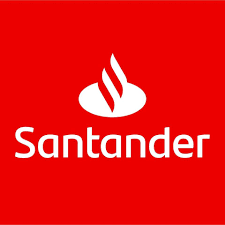

> # Introduction
> 
> In this challenge, Santander invites Kagglers to help them identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. The data provided for this competition has the same structure as the real data they have available to solve this problem.

# Imports

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import os
import logging
import datetime

import lightgbm as lgb

from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# Load data

In [ ]:
IS_LOCAL = False
if(IS_LOCAL):
    PATH="../input/Santander/"
else:
    PATH="../input/"
os.listdir(PATH)

In [ ]:
# import Dataset to play with it
train= pd.read_csv("../input/santander-customer-transaction-prediction/train.csv")
test = pd.read_csv('../input/santander-customer-transaction-prediction/test.csv')
sample_submission = pd.read_csv('../input/santander-customer-transaction-prediction/sample_submission.csv')
sample_submission.head()

# Data exploration

In [ ]:
train.shape, test.shape, sample_submission.shape

In [ ]:
train.head()

In [ ]:
train.info()

> **Reducing memory size about %50**
> Because we make a lot of calculations in this kernel, we'd better reduce the size of the data.

In [ ]:
def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",df[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",df[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return df, NAlist

In [ ]:
train, NAlist = reduce_mem_usage(train)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

In [ ]:
test, NAlist = reduce_mem_usage(test)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

In [ ]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [ ]:
missing_data(train)

In [ ]:
missing_data(test)

> **Numerical values Describe**
> *  There are no missing data in train and test datasets. Let's check the numerical values in train and test dataset.

In [ ]:
train.describe().T

In [ ]:
test.describe().T

# Data Visualization

In [ ]:
sns.countplot(train['target'], palette='Set3')

In [ ]:
print("There are {}% target values with 1 on the train data".format(100 * train["target"].value_counts()[1]/train.shape[0]))

In [ ]:
f,ax=plt.subplots(1,2,figsize=(20,10))
train[train['target']==0].var_0.plot.hist(ax=ax[0],bins=20,edgecolor='black',color='red')
ax[0].set_title('target= 0')
x1=list(range(0,85,5))
ax[0].set_xticks(x1)
train[train['target']==1].var_0.plot.hist(ax=ax[1],color='green',bins=20,edgecolor='black')
ax[1].set_title('target= 1')
x2=list(range(0,85,5))
ax[1].set_xticks(x2)
plt.show()


In [ ]:
train["var_10"].hist();

In [ ]:
train["var_52"].hist();

In [ ]:
train["var_181"].hist();

In [ ]:
sns.set(rc={'figure.figsize':(9,7)})
sns.distplot(train['target']);

> **The target in dataset is imbalance**

In [ ]:
sns.violinplot(data=train,x="target", y="var_10")

In [ ]:
sns.violinplot(data=train,x="target", y="var_110")

In [ ]:
sns.violinplot(data=train,x="target", y="var_81")

In [ ]:
train[train.columns[2:]].mean().plot(kind='hist', color='#ffa600');plt.title('Mean Frequency');

In [ ]:
features = train.columns.values[2:202]
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train and test set")
sns.distplot(train[features].mean(axis=0),color="magenta",kde=True,bins=120, label='train')
sns.distplot(test[features].mean(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train and test set")
sns.distplot(train[features].mean(axis=1),color="green", kde=True,bins=120, label='train')
sns.distplot(test[features].mean(axis=1),color="blue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per row in the train and test set")
sns.distplot(train[features].std(axis=1),color="black", kde=True,bins=120, label='train')
sns.distplot(test[features].std(axis=1),color="red", kde=True,bins=120, label='test')
plt.legend();plt.show()

In [ ]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per column in the train and test set")
sns.distplot(train[features].std(axis=0),color="blue",kde=True,bins=120, label='train')
sns.distplot(test[features].std(axis=0),color="green", kde=True,bins=120, label='test')
plt.legend(); plt.show()

# Binary Classification

In [ ]:
train['target'].unique()

In [ ]:
train['target'].value_counts()

> A large part of the data is unbalanced, but how can we solve it?

In [ ]:
def check_balance(df,target):
    check=[]
    # written by MJ Bahmani for binary target
    print('size of data is:',df.shape[0] )
    for i in [0,1]:
        print('for target  {} ='.format(i))
        print(df[target].value_counts()[i]/df.shape[0]*100,'%')

In [ ]:
check_balance(train,'target')

In [ ]:
#skewness and kurtosis
print("Skewness: %f" % train['target'].skew())
print("Kurtosis: %f" % train['target'].kurt())

# Features correlation

In [ ]:
%%time
correlations = train[features].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]
correlations.head(10)

In [ ]:
correlations.tail(10)

# Duplicate values

In [ ]:
%%time
features = train.columns.values[2:202]
unique_max_train = []
unique_max_test = []
for feature in features:
    values = train[feature].value_counts()
    unique_max_train.append([feature, values.max(), values.idxmax()])
    values = test[feature].value_counts()
    unique_max_test.append([feature, values.max(), values.idxmax()])

In [ ]:
np.transpose((pd.DataFrame(unique_max_train, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head())
#TRAIN SET

In [ ]:
np.transpose((pd.DataFrame(unique_max_test, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head())
#TEST SET

# Feature engineering

In [ ]:
%%time
idx = features = train.columns.values[2:202]
for df in [test, train]:
    df['sum'] = df[idx].sum(axis=1)  
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)

In [ ]:
train[train.columns[202:]].head()

In [ ]:
test[test.columns[201:]].head()

In [ ]:
def plot_new_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,4,figsize=(18,8))

    for feature in features:
        i += 1
        plt.subplot(2,4,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=11)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

> Let's check the distribution of these new, engineered features.
> 
> We plot first the distribution of new features, grouped by value of corresponding target values.

In [ ]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
features = train.columns.values[202:]
plot_new_feature_distribution(t0, t1, 'target: 0', 'target: 1', features)

In [ ]:
features = train.columns.values[202:]
plot_new_feature_distribution(train, test, 'train', 'test', features)

In [ ]:
features = [c for c in train.columns if c not in ['ID_code', 'target']]
for feature in features:
    train['r2_'+feature] = np.round(train[feature], 2)
    test['r2_'+feature] = np.round(test[feature], 2)
    train['r1_'+feature] = np.round(train[feature], 1)
    test['r1_'+feature] = np.round(test[feature], 1)

In [ ]:
print('Train and test columns: {} {}'.format(len(train.columns), len(test.columns)))

# Modelling

In [ ]:
features = [c for c in train.columns if c not in ['ID_code', 'target']]
target = train['target']

> **Hyperparameters for the model.**

In [ ]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}

In [ ]:
folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=44000)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 1000000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

# Submission

In [ ]:
sub_enes = pd.DataFrame({"ID_code":test["ID_code"].values})
sub_enes["target"] = predictions
sub_enes.to_csv("submission.csv", index=False)

# **References & credits **

1. https://www.kaggle.com/gpreda/elo-world-high-score-without-blending
2. https://www.kaggle.com/chocozzz/santander-lightgbm-baseline-lb-0-897
3. https://www.kaggle.com/brandenkmurray/nothing-works
4. https://www.kaggle.com/dansbecker/permutation-importance
5. https://www.kaggle.com/dansbecker/partial-plots
6. https://www.kaggle.com/miklgr500/catboost-with-gridsearch-cv
7. https://www.kaggle.com/dromosys/sctp-working-lgb
8. https://www.kaggle.com/gpreda/santander-eda-and-prediction
9. https://www.kaggle.com/dansbecker/permutation-importance
10. https://www.kaggle.com/dansbecker/partial-plots
11. https://www.kaggle.com/dansbecker/shap-values
12. https://docs.microsoft.com/en-us/azure/machine-learning/studio/algorithm-choice
13. https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65
14. https://www.kaggle.com/brandenkmurray/nothing-works
15. https://www.kaggle.com/gpreda/santander-eda-and-prediction
16. https://www.kaggle.com/mjbahmani/santander-ml-explainability#--Santander-ML-Explainability--